# 1.0 Library

In [26]:
import torch 
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from transformers import ViTFeatureExtractor, ViTModel
from torchvision.models import resnet18
import torch.nn as nn

import sys
sys.path.append('..')

# 2.0 Load data

In [51]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)


100%|████████████████████████████████████████████████████| 9.91M/9.91M [01:19<00:00, 125kB/s]
100%|████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 257kB/s]
100%|███████████████████████████████████████████████████| 1.65M/1.65M [00:16<00:00, 98.8kB/s]
100%|███████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 4.56MB/s]


In [19]:
train_images = torch.cat([trainset[i][0] for i in range(len(trainset))]).numpy()
train_labels = np.array([trainset[i][1] for i in range(len(trainset))])

test_images = torch.cat([testset[i][0] for i in range(len(testset))]).numpy()
test_labels = np.array([testset[i][1] for i in range(len(testset))])

print(f"MNIST Training Data: {train_images.shape}, Labels: {train_labels.shape}")
print(f"MNIST Test Data: {test_images.shape}, Labels: {test_labels.shape}")


MNIST Training Data: (60000, 28, 28), Labels: (60000,)
MNIST Test Data: (10000, 28, 28), Labels: (10000,)


# 03. Visualize Sample Images


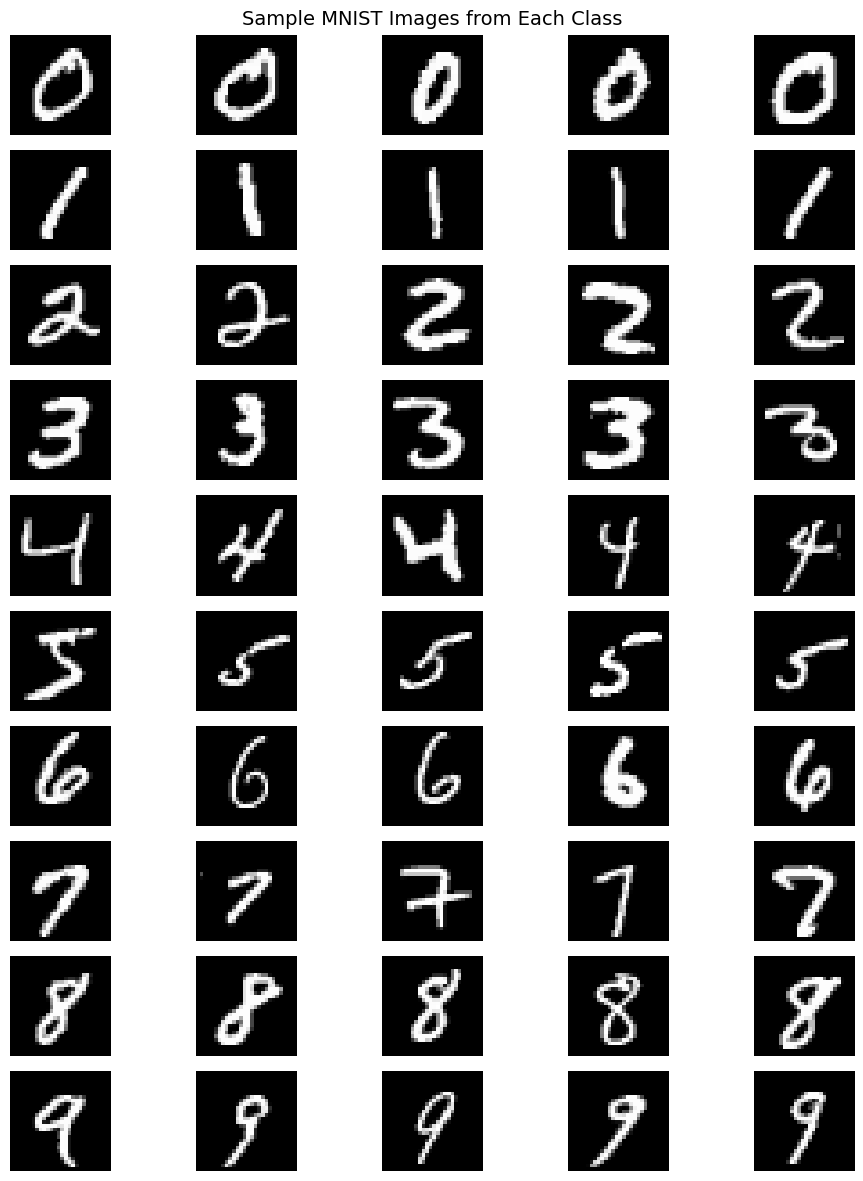

In [20]:
fig, axes = plt.subplots(10, 5, figsize=(10, 12))
fig.suptitle("Sample MNIST Images from Each Class", fontsize=14)
for i in range(10):
    class_images = train_images[train_labels == i]
    for j in range(5):
        ax = axes[i, j]
        ax.imshow(class_images[j].squeeze(), cmap="gray")
        ax.axis("off")
        if j == 0:
            ax.set_ylabel(f"Digit {i}", fontsize=12)

plt.tight_layout()
plt.show()


 # 5.0 Image Quality & Variability Analysis

# 5.0 Embeddings

In [32]:
from torch.utils.data import DataLoader, Subset
from torchvision.models import resnet18
from transformers import ViTFeatureExtractor, ViTModel
import multiprocessing
from concurrent.futures import ThreadPoolExecutor

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.Grayscale(num_output_channels=3), 
    transforms.ToTensor(),  
])

trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)

num_train_samples = 5000  
num_test_samples = 1000   

train_indices = random.sample(range(len(trainset)), num_train_samples)
test_indices = random.sample(range(len(testset)), num_test_samples)

train_subset = Subset(trainset, train_indices)
test_subset = Subset(testset, test_indices)

batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False, num_workers=10)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=10)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet18(pretrained=True).to(device)
resnet = nn.Sequential(*list(resnet.children())[:-1]) 

feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k").to(device)

class MNIST_Encoder(nn.Module):
    def __init__(self):
        super(MNIST_Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64 * 56 * 56, 128)  
        )

    def forward(self, x):
        return self.encoder(x)

mnist_encoder = MNIST_Encoder().to(device)

# Define Embedding Extraction Functions
def extract_embeddings(model, dataloader, model_name):
    """ Extract embeddings using a given model in parallel """
    embeddings, labels = [], []
    
    for images, lbls in dataloader:
        images = images.to(device)

        with torch.no_grad():
            if model_name == "ViT":
                inputs = feature_extractor(images, return_tensors="pt")["pixel_values"].to(device)
                outputs = model(inputs).last_hidden_state[:, 0, :] 
            else:
                outputs = model(images)
                if outputs.dim() > 2:
                    outputs = outputs.view(outputs.shape[0], -1) 

        embeddings.append(outputs.cpu().numpy())
        labels.append(lbls.numpy())

    return np.vstack(embeddings), np.hstack(labels)

def parallel_embedding_extraction():
    """ Run embedding extraction in parallel using multiple CPUs """
    print("= Running Parallel Embedding Extraction...")

    with ThreadPoolExecutor(max_workers=30) as executor:
        future_resnet = executor.submit(extract_embeddings, resnet, train_loader, "ResNet")
        future_vit = executor.submit(extract_embeddings, vit_model, train_loader, "ViT")
        future_mnist = executor.submit(extract_embeddings, mnist_encoder, train_loader, "MNIST_Encoder")

        resnet_embeddings, resnet_labels = future_resnet.result()
        vit_embeddings, vit_labels = future_vit.result()
        mnist_embeddings, mnist_labels = future_mnist.result()

    print("Embedding Extraction Completed!")

    return {
        "ResNet": (resnet_embeddings, resnet_labels),
        "ViT": (vit_embeddings, vit_labels),
        "MNIST_Encoder": (mnist_embeddings, mnist_labels)
    }

embeddings_dict = parallel_embedding_extraction()


= Running Parallel Embedding Extraction...
Embedding Extraction Completed!
Saved Embeddings Successfully!


In [34]:
embeddings_dict

{'ResNet': (array([[1.414177  , 1.022818  , 2.3657017 , ..., 0.74613285, 1.5236037 ,
          2.3853383 ],
         [0.36121777, 0.43228552, 0.8222989 , ..., 1.7074834 , 0.25832006,
          0.29846147],
         [0.7825126 , 0.5064652 , 0.9628993 , ..., 0.5616739 , 0.98000383,
          0.26633433],
         ...,
         [0.10216475, 0.06429802, 0.21974388, ..., 0.42917088, 1.4723506 ,
          0.73957545],
         [0.34443986, 0.15662205, 1.1225483 , ..., 0.51628524, 1.2606081 ,
          0.88376355],
         [0.3072127 , 1.3165249 , 0.6139645 , ..., 0.70937836, 1.3280989 ,
          0.34269443]], dtype=float32),
  array([3, 6, 9, ..., 7, 0, 1])),
 'ViT': (array([[ 0.21100025,  0.10112654, -0.2457974 , ...,  0.01197836,
           0.01293154,  0.09763328],
         [ 0.211568  ,  0.09854966, -0.24485429, ...,  0.01226656,
           0.01778107,  0.09601607],
         [ 0.20752788,  0.09978499, -0.24447756, ...,  0.01174625,
           0.01514378,  0.09600895],
         ...,
   

In [52]:
import sys
sys.path.append('..')
import os

import os
import numpy as np

save_dir = "../data"
os.makedirs(save_dir, exist_ok=True)

np.save(os.path.join(save_dir, "resnet_embeddings.npy"), embeddings_dict["ResNet"][0])
np.save(os.path.join(save_dir, "vit_embeddings.npy"), embeddings_dict["ViT"][0])
np.save(os.path.join(save_dir, "mnist_encoder_embeddings.npy"), embeddings_dict["MNIST_Encoder"][0])

train_labels = embeddings_dict["ResNet"][1]
np.save(os.path.join(save_dir, "train_labels.npy"), train_labels)
print("Embeddings and labels saved successfully in 'data/' directory!")


Embeddings and labels saved successfully in 'data/' directory!


In [53]:
if os.path.exists(os.path.join(save_dir, "train_labels.npy")):
    labels = np.load(os.path.join(save_dir, "train_labels.npy"))
    print(f"Loaded Labels: {labels.shape}")
else:
    raise FileNotFoundError("L train_labels.npy not found! Ensure you have saved it correctly.")


Loaded Labels: (5000,)


# PCA & t-SNE Visualization

Loaded Data Shapes: ResNet: (5000, 512), ViT: (5000, 768), MNIST_Encoder: (5000, 128)
Labels Shape: (5000,)
= Reducing dimensionality for pca_tsne...
= Reducing dimensionality for pca_tsne...
= Reducing dimensionality for pca_tsne...
 Dimensionality Reduction Complete!


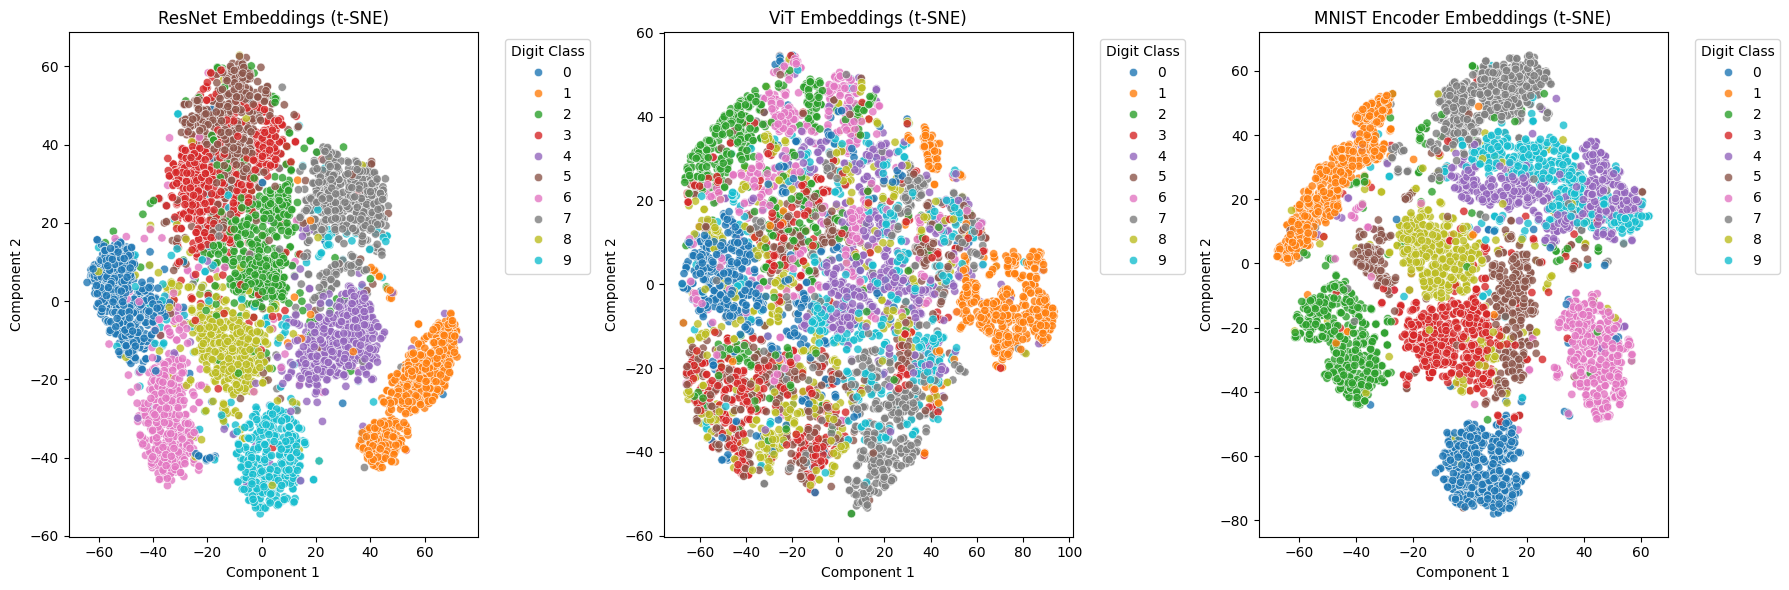

In [56]:
# =Ì Step 1: Import Required Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

save_dir = "../data"

required_files = [
    "resnet_embeddings.npy", "vit_embeddings.npy", "mnist_encoder_embeddings.npy", "train_labels.npy"
]

missing_files = [fname for fname in required_files if not os.path.exists(os.path.join(save_dir, fname))]
if missing_files:
    raise FileNotFoundError(f"L Missing files: {missing_files}. Ensure you have extracted and saved embeddings.")

resnet_embeddings = np.load(os.path.join(save_dir, "resnet_embeddings.npy"))
vit_embeddings = np.load(os.path.join(save_dir, "vit_embeddings.npy"))
mnist_embeddings = np.load(os.path.join(save_dir, "mnist_encoder_embeddings.npy"))

labels = np.load(os.path.join(save_dir, "train_labels.npy"))
labels = labels[:len(resnet_embeddings)] 

print(f"Loaded Data Shapes: ResNet: {resnet_embeddings.shape}, ViT: {vit_embeddings.shape}, MNIST_Encoder: {mnist_embeddings.shape}")
print(f"Labels Shape: {labels.shape}")

def reduce_dimensionality(embeddings, method="pca_tsne"):
    """
    Reduce high-dimensional embeddings using PCA and t-SNE.
    
    :param embeddings: High-dimensional embeddings (e.g., 768D for ViT)
    :param method: "pca" for PCA, "tsne" for t-SNE, "pca_tsne" for PCA + t-SNE
    :return: 2D reduced embeddings
    """
    print(f"= Reducing dimensionality for {method}...")
    
    if method == "pca":
        pca = PCA(n_components=2)
        return pca.fit_transform(embeddings)
    
    elif method == "tsne":
        tsne = TSNE(n_components=2, perplexity=30, random_state=42)
        return tsne.fit_transform(embeddings)
    
    elif method == "pca_tsne":
        pca = PCA(n_components=50)  # Reduce to 50D first
        reduced_data = pca.fit_transform(embeddings)
        tsne = TSNE(n_components=2, perplexity=30, random_state=42)
        return tsne.fit_transform(reduced_data)

    else:
        raise ValueError("L Invalid method. Choose from 'pca', 'tsne', or 'pca_tsne'.")

# Apply PCA + t-SNE
resnet_2D = reduce_dimensionality(resnet_embeddings, method="pca_tsne")
vit_2D = reduce_dimensionality(vit_embeddings, method="pca_tsne")
mnist_2D = reduce_dimensionality(mnist_embeddings, method="pca_tsne")

print(" Dimensionality Reduction Complete!")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

def plot_embeddings(ax, embeddings_2D, title, labels):
    """ Plot 2D embeddings with color-coded MNIST labels in a subplot """
    sns.scatterplot(x=embeddings_2D[:, 0], y=embeddings_2D[:, 1], hue=labels, palette="tab10", alpha=0.8, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.legend(title="Digit Class", bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot all three models in the same row
plot_embeddings(axes[0], resnet_2D, "ResNet Embeddings (t-SNE)", labels)
plot_embeddings(axes[1], vit_2D, "ViT Embeddings (t-SNE)", labels)
plot_embeddings(axes[2], mnist_2D, "MNIST Encoder Embeddings (t-SNE)", labels)

plt.tight_layout()
plt.show()